In [1]:
import os
import argparse
import numpy as np
import tensorflow as tf
from epi.models import Parameter, Model
import time
import matplotlib.pyplot as plt
from epi.STG_Circuit import Simulate, Simulate_all, NetworkFreq
from epi.util import pairplot, plot_T_x

In [2]:
# 1. Specify the V1 model for EPI.
D = 2
g_el = Parameter("g_el", 1, lb=4., ub=8.)
g_synA = Parameter("g_synA", 1, lb=0.01, ub=4.)

# Define model
name = "STG"
parameters = [g_el, g_synA]
model = Model(name, parameters)

In [36]:
dt = 0.025
T = 1000
sigma_I = 0.
simulate = Simulate(dt, T, sigma_I)

In [37]:
lb = np.concatenate([p.lb for p in model.parameters], axis=0)
ub = np.concatenate([p.ub for p in model.parameters], axis=0)

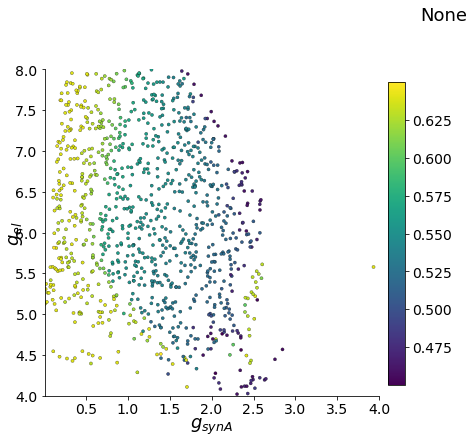

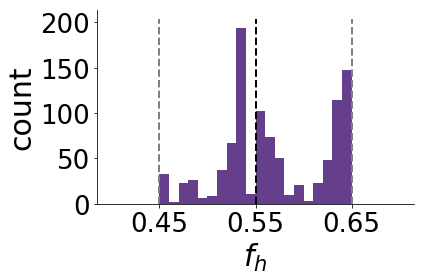

In [38]:
def accept_inds(T_x, mu, std):
    return np.logical_and(-2*std + mu < T_x[:,0], 
                          T_x[:,0] < mu + 2*std)

num_keep = 1000
num_plot = 1000
M = 1000
zs = []
T_xs = []

freqs = [0.55]
std = 0.05

for i,freq in enumerate(freqs):
    mu = np.array([freq])
    network_freq = NetworkFreq(dt, T, sigma_I, mu)
    model.set_eps(network_freq)
    fontsize = 30
    num_found = 0
    z = None
    T_x = None
    count = 0
    while (num_found < num_keep):
        count += 1
        _z = np.zeros((M, D))
        for d in range(D):
            _z[:,d] = np.random.uniform(lb[d], ub[d], (M,))
        _T_x = model.eps(_z).numpy()

        inds = accept_inds(_T_x, freq, std)
        _z = _z[inds, :]
        _T_x = _T_x[inds, :]
        num_found += _z.shape[0]

        if (z is None):
            z = _z
            T_x = _T_x
        else:
            z = np.concatenate((z, _z), axis=0)
            T_x = np.concatenate((T_x, _T_x), axis=0)
        print('%d %d/%d\r' % (count, num_found, num_keep), end='')

    num_found = z.shape[0]

    # reduce to num_keep
    z = z[:num_keep]
    T_x = T_x[:num_keep]
    
    z_labels = [r'$g_{el}$', r'$g_{synA}$']
    fig = pairplot(z[:num_plot], np.arange(2), z_labels, figsize=(6,6),
                   c=T_x[:,0],
                   fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))
    #plt.savefig(figdir + name + '_z.png')

    T_x_sim = model.eps(z).numpy()

    plot_T_x(T_x[:,0], T_x_sim[:,0], x_mean=freq, x_std=std, xmin=freq-3*std, xmax=freq+3.*std, xlabel=r'$f_h$', fontsize=30)
    plt.tight_layout()
    #plt.savefig(figdir + name + '_Tx.png')


    zs.append(z)
    T_xs.append(T_x)

(-0.07, 0.0)

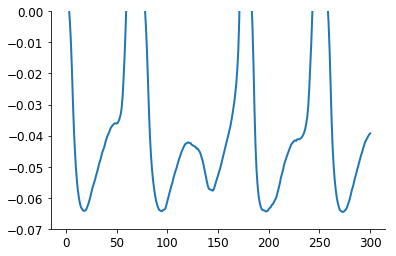

In [6]:
g_el = 6.*np.ones((1,1))
g_synA = 2.*np.ones((1,1))
simulate = Simulate_all(dt, T, 5e-12)
x_t = simulate(g_el, g_synA)
plt.plot(x_t[:,2])
plt.ylim([-0.07, 0.])

2.8454048e-07


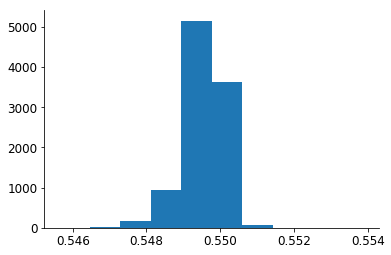

In [30]:
M = 1000
_sigma_I = 1.e-12
g_el = 6.5*np.ones((M,1))
g_synA = 1.5*np.ones((M,1))
network_freq = NetworkFreq(dt, T, _sigma_I, mu)
T_x = network_freq(g_el, g_synA).numpy()
plt.hist(T_x[:,0])
print(np.var(T_x[:,0]))

In [16]:
def hessian(z, f):
    """Calculates the Hessian.

    :param z: Samples from distribution.
    :type z: np.ndarray
    :param f: Function to compute hessian of
    :type f: func
    :returns: Hessian of log probability with respect to z.
    :rtype: np.ndarray
    """
    z = _set_z_type(z)
    z = tf.Variable(initial_value=z, trainable=True)
    hess_z = _hessian(z, f)
    del z  # Get rid of dummy variable.
    return hess_z.numpy()

def _hessian(z, f):
    with tf.GradientTape(persistent=True) as tape:
        f_z = f(z)
        dfdz = tape.gradient(f_z, z)
    return tape.batch_jacobian(dfdz, z)

def _set_z_type(z):
    if type(z) is list:
        z = np.ndarray(z)
    z = z.astype(np.float32)
    return z

In [27]:
network_freq = NetworkFreq(dt, 45, 0., mu)
Ds = [param.D for param in model.parameters]
def f(z):
    ind = 0
    zs = []
    for D in Ds:
        zs.append(z[:, ind : (ind + D)])
        ind += D
    return network_freq(*zs)

@tf.function
def temp(z):
    T_x = f(z)
    return T_x[:,0]
z_star = np.array([[6.5, 1.5]], dtype=np.float32)
print(temp(z_star))

tf.Tensor([0.5], shape=(1,), dtype=float32)


In [28]:
@tf.function
def temp2(z):
    return 2*tf.reduce_sum(z, axis=1, keepdims=True)**3

In [29]:
df2dz2 = hessian(z_star, temp)
print(df2dz2)

(1, 2)
[[[0. 0.]
  [0. 0.]]]


In [41]:
"""z_star = np.array([[6.5, 1.5]])
print(z_star)
network_freq = NetworkFreq(dt, 50, sigma_I, mu)
model.set_eps(network_freq)"""

[[6.5 1.5]]


In [ ]:
print(df2dz2)